![logo_ironhack_blue 7](https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png)

# Lab | Making Predictions with Logistic Regression
***

## Introduction
***
In this lab, you will be using the [Sakila](https://dev.mysql.com/doc/sakila/en/) database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

### Objectives

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X). 
2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our **TARGET** (y) variable.
3. Read the data into a Pandas dataframe.  At this point you should have 1000 rows.  Number of columns depends on the number of features you chose.
4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.
5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.
6. Evaluate the results.

## Import Libraries
***

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymysql
from sqlalchemy import create_engine
import getpass

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import my_functions

password = getpass.getpass()# To get the password without showing the input

## Data Collection
***

### Load the Data

To predict which films will be rented, 3 groups of data from the [Sakila](https://dev.mysql.com/doc/sakila/en/) database will be queried:
1. **film table**: columns extracted directly from the film table (FROM clause) & derivates such as category and language (first three JOIN clauses)
2. **prolific actor count**: sinthesized data about the most popular actors that appear in each movie (first LEFT JOIN clause)
3. **rental & inventory tables**: data relative to the film's rental activity and inventory stock (last two LEFT JOIN clauses)

*See [Sakila's table relationship diagram](https://camo.githubusercontent.com/94c7105d3e2fdde2318c3eed4d45ccca11bdc064f38402f9a2bba22951286bd9/68747470733a2f2f656475636174696f6e2d7465616d2d323032302e73332d65752d776573742d312e616d617a6f6e6177732e636f6d2f646174612d616e616c79746963732f64617461626173652d73616b696c612d736368656d612e706e67)*

In [3]:
# Create connection string & engine
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

# SQL Query
query = '''
SELECT f.film_id, f.length, f.rating, f.rental_duration, f.rental_rate, f.special_features, 
       f.release_year, l.name AS language, c.name AS category, f.replacement_cost,
       COUNT(ta.actor_id) AS prolific_actor_count,
       IFNULL(rc.rental_count, 0) AS rental_count,
       IFNULL(rc.rental_count / fco.film_copies, 0) AS rental_count_per_copy
FROM sakila.film f
JOIN sakila.language l ON f.language_id = l.language_id
JOIN sakila.film_category fc ON f.film_id = fc.film_id
JOIN sakila.category c ON fc.category_id = c.category_id
LEFT JOIN (
    SELECT fa.actor_id, fa.film_id
    FROM (
      SELECT a.actor_id
      FROM sakila.actor a
      JOIN sakila.film_actor fa ON a.actor_id = fa.actor_id
      GROUP BY a.actor_id
      ORDER BY COUNT(fa.film_id) DESC
      LIMIT 20
    ) a
    JOIN sakila.film_actor fa ON a.actor_id = fa.actor_id
) ta ON f.film_id = ta.film_id
LEFT JOIN (SELECT film_id, count(inventory_id) AS film_copies FROM sakila.inventory GROUP BY film_id) fco ON f.film_id = fco.film_id
LEFT JOIN (SELECT i.film_id, count(r.rental_id) AS rental_count FROM sakila.inventory i JOIN sakila.rental r ON i.inventory_id = r.inventory_id GROUP BY i.film_id) rc ON f.film_id = rc.film_id
GROUP BY f.film_id, f.length, f.rating, f.rental_duration, f.rental_rate, f.special_features, 
         f.release_year, l.name, c.name, f.replacement_cost;
'''
# Run query and create DataFrame
df_X = pd.read_sql_query(query, engine)

To create out **TARGET** variable (y), we query the list of all films and whether they were rented in may 2005 or not:

In [4]:
# SQL Query
query_target = '''
SELECT f.film_id, IF(rental_count is NULL, False, True) AS rented_in_may 
FROM sakila.film f
LEFT JOIN 
	(SELECT i.film_id, COUNT(r.rental_date) as rental_count
    FROM sakila.rental r
    JOIN sakila.inventory i
    ON r.inventory_id = i.inventory_id
    WHERE MONTH(r.rental_date) = 5 AND YEAR(r.rental_date) = 2005
    GROUP BY i.film_id) as r
ON f.film_id = r.film_id
GROUP BY f.film_id;
'''
# Run query and create DataFrame
df_y = pd.read_sql_query(query_target, engine)

In [5]:
# Concatenate X and y DataFrames for initial analysis
df_raw = pd.concat([df_X.set_index('film_id'), df_y.set_index('film_id')], axis=1, join='outer')

### Initial Data Overview

In [6]:
# Display first 5 rows
display(df_raw.head())

# Display column data types
display(df_raw.dtypes)

# Display data description
display(df_raw.describe())

,length,rating,rental_duration,rental_rate,special_features,release_year,language,category,replacement_cost,prolific_actor_count,rental_count,rental_count_per_copy,rented_in_may
film_id,,,,,,,,,,,,,
19,113,PG,6,0.99,"Commentaries,Deleted Scenes,Behind the Scenes",2006,English,Action,20.99,1,21,3.5000,1
21,129,R,3,4.99,"Commentaries,Behind the Scenes",2006,English,Action,17.99,2,22,3.6667,1
29,168,NC-17,5,2.99,"Trailers,Commentaries,Deleted Scenes",2006,English,Action,11.99,2,10,5.0000,1
38,68,NC-17,6,0.99,"Trailers,Commentaries,Deleted Scenes,Behind th...",2006,English,Action,25.99,0,0,0.0000,0
56,129,G,6,2.99,"Trailers,Commentaries",2006,English,Action,15.99,0,18,3.6000,1


length                     int64
rating                    object
rental_duration            int64
rental_rate              float64
special_features          object
release_year               int64
language                  object
category                  object
replacement_cost         float64
prolific_actor_count       int64
rental_count               int64
rental_count_per_copy    float64
rented_in_may              int64
dtype: object

,length,rental_duration,rental_rate,release_year,replacement_cost,prolific_actor_count,rental_count,rental_count_per_copy,rented_in_may
count,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,115.272000,4.985000,2.980000,2006.0,19.984000,0.71400,16.044000,3.370288,0.686000
std,40.426332,1.411654,1.646393,0.0,6.050833,0.84197,7.348065,0.890134,0.464349
min,46.000000,3.000000,0.990000,2006.0,9.990000,0.00000,0.000000,0.000000,0.000000
25%,80.000000,4.000000,0.990000,2006.0,14.990000,0.00000,11.000000,3.000000,0.000000
50%,114.000000,5.000000,2.990000,2006.0,19.990000,1.00000,16.000000,3.500000,1.000000
75%,149.250000,6.000000,4.990000,2006.0,24.990000,1.00000,21.000000,3.833300,1.000000
max,185.000000,7.000000,4.990000,2006.0,29.990000,4.00000,34.000000,5.000000,1.000000


### Column Analysis Summary
***
column|description|use in model|actions
------|-----------|------------|-------
film_id|PK, film identifier|NOK|ID, drop for model building
length|length of film in minutes|OK|-
rating|movie audience rating|OK|-
rental_duration|rental duration for the corresponding rental rate|NOK|drop for model building - use to create variable 'daily_rental_rate' = rental_rate / rental duration
rental_rate|rate to rent the movie for the duration specified in 'rental_duration'|NOK|drop for model building - use to create variable 'daily_rental_rate' = rental_rate / rental duration
special_features|list of film's extra content|OK|convert column to total_special_features
release_year|film's release year|NOK|drop, all values are the same
language|film's language|NOK|drop, all values are the same
category|film's audience category (PG-13, NC-17, R, PG, G)|OK|-
replacement_cost|cost of the film|NOK|use to create variable rental_rate_per_replacement_cost
prolific_actor_count|number of prolific actors in the film. A prolific actor is one who ranks among the top 10% of actors in terms of the number of movies they have appeared in.|OK|-
rental_count|number of rentals per month|OK|-
rental_count_per_copy|number of rentals per inventory copy|OK|-

### New calculated columns:
column|description|formula
------|-----------|-------
daily_rental_rate|rental rate for one day|rental_rate / rental_duration
rental_rate_per_replacement_cost|representation of how expensive the customer can perceive the film's rental rate is, relative to buying a copy in a store|daily_rental_rate / replacement_cost

In [7]:
# Add calculated columns to modeling DataFrame
df_raw['daily_rental_rate'] = df_raw['rental_rate']/df_raw['rental_duration']
df_raw['rental_rate_per_replacement_cost'] = df_raw['daily_rental_rate']/df_raw['replacement_cost']

In [8]:
# Convert special_features column

# Check values in column
df_raw['special_features'].value_counts()

# Add new column special_features_count -> Count the number of commas to extract number of special_features
df_raw['special_features_count'] = [ x.count(',') + 1 for x in df_raw['special_features']]

# Check conversion
df_raw[['special_features', 'special_features_count']].head()

,special_features,special_features_count
film_id,,
19,"Commentaries,Deleted Scenes,Behind the Scenes",3
21,"Commentaries,Behind the Scenes",2
29,"Trailers,Commentaries,Deleted Scenes",3
38,"Trailers,Commentaries,Deleted Scenes,Behind th...",4
56,"Trailers,Commentaries",2


In [9]:
# List modeling (OK) columns
modeling_columns = ['length', 'rating', 'special_features_count', 'category', 
                    'prolific_actor_count', 'rental_count', 'rental_count_per_copy',
                    'daily_rental_rate','rental_rate_per_replacement_cost','rented_in_may']

df = df_raw[modeling_columns].copy()

## Data Preprocessing
***

### Handle Missing Values

In [10]:
# Check for null values in df
display(df.isnull().sum())

length                              0
rating                              0
special_features_count              0
category                            0
prolific_actor_count                0
rental_count                        0
rental_count_per_copy               0
daily_rental_rate                   0
rental_rate_per_replacement_cost    0
rented_in_may                       0
dtype: int64

+ No null values are found in our datasets

### Split Data into Training and Test Sets

In [11]:
# Separate the features from the target
y = df['rented_in_may']
X = df.drop(['rented_in_may'], axis=1)

In [12]:
# Generate the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420)

In [13]:
# Add columns to X_train and X_test and transform into DataFrame
X_train = pd.DataFrame(X_train, columns = X.columns, index=X_train.index)
X_test  = pd.DataFrame(X_test,  columns = X.columns, index=X_test.index)

In [14]:
# Split X_train into numerical and categorical columns
X_train_num = X_train.select_dtypes(include='number')
X_train_cat = X_train.select_dtypes(include='object')

# Split X_test into numerical and categorical columns
X_test_num = X_test.select_dtypes(include='number')
X_test_cat = X_test.select_dtypes(include='object')

### Handle Numerical Variables

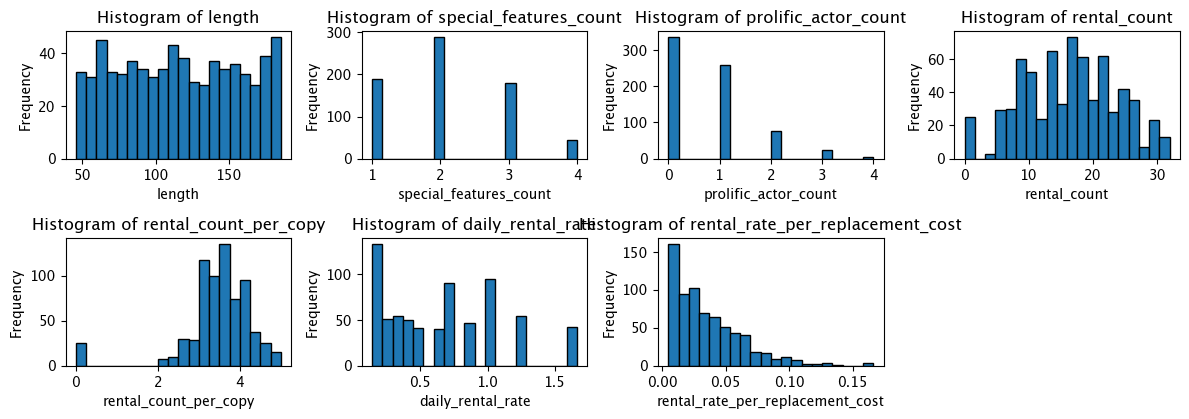

,Column,Skew,Outside Interval
0,length,0.013220,False
1,special_features_count,0.346992,False
2,prolific_actor_count,1.161234,False
3,rental_count,-0.052124,False
4,rental_count_per_copy,-2.037477,True
5,daily_rental_rate,0.711469,False
6,rental_rate_per_replacement_cost,1.458551,False


In [15]:
# Plot histograms
my_functions.plot_numeric_columns(X_train_num, 'histogram')

# Analyze skewness
my_functions.analyze_skewness(X_train_num)

+ Only 1 column appears to be out of skewness interval -> **rental_count_per_copy**
+ PowerTransformer + Scaling transformations will be applied

In [16]:
# Apply PowerTransformer

# Select PowerTransformer with yeo-johnson method
transformer = PowerTransformer(method='yeo-johnson')

# Fit transformer with TRAIN data
transformer.fit(X_train_num)

# Save transformer to use later
path = "transformers/"
file_name = "power_transformer.pkl"
my_functions.save_pickle_file(path, file_name, transformer)

# Transform X_train_num & X_test_num with fitted transformer -> output is a np.array
X_train_num_transformed = transformer.transform(X_train_num)
X_test_num_transformed = transformer.transform(X_test_num)

# Add columns to np.array to create a DataFrame
# IMPORTANT -> index = X_train/test_nom.index -> ensures we maintain index order & match when we concatenate
X_train_num_transformed_df = pd.DataFrame(X_train_num_transformed, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_transformed_df = pd.DataFrame(X_test_num_transformed, columns=X_test_num.columns, index=X_test_num.index)


The new directory is created!


In [17]:
# Check skewness after transformation
my_functions.analyze_skewness(X_train_num_transformed_df)

,Column,Skew,Outside Interval
0,length,-0.112050,False
1,special_features_count,-0.020210,False
2,prolific_actor_count,0.160454,False
3,rental_count,-0.137817,False
4,rental_count_per_copy,-0.010929,False
5,daily_rental_rate,0.065242,False
6,rental_rate_per_replacement_cost,0.195049,False


+ Skewness is now **OK** in all columns
+ Scaling will be done to both Categorical & Numerical columns **after** the categorical transformations.

### Handle Categorical Variables

1. Split categorical columns into nominal and ordinal
2. Transform nominal columns with OneHotEncoder
3. Transform ordinal columns with .replace()

In [18]:
# Check categorical values to split into nominal & ordinal
for col in X_train_cat.columns:
   display(X_train_cat[col].value_counts())

PG-13    152
NC-17    146
PG       144
R        134
G        124
Name: rating, dtype: int64

Drama          54
Sports         53
Action         50
Sci-Fi         49
Games          47
Animation      47
Documentary    44
Travel         43
Comedy         43
Family         42
New            41
Foreign        41
Music          37
Horror         37
Classics       36
Children       36
Name: category, dtype: int64

+ Nominal columns:
    + category
+ Ordinal columns:
    + rating

In [19]:
# Split categorical columns into nominal and ordinal
X_train_cat_nom = X_train_cat[['category']].copy()
X_train_cat_ord = X_train_cat[['rating']].copy()
X_test_cat_nom = X_test_cat[['category']].copy()
X_test_cat_ord = X_test_cat[['rating']].copy()

In [20]:
# Transform nominal columns with OneHotEncoder

# Select OneHotEnconder to add as many binary columns as values per column to the DataFrame
encoder = OneHotEncoder()

# Fit encoder
encoder.fit(X_train_cat_nom)

# Save encoder to use later
path = "encoders/"
file_name = "one_hot_encoder.pkl"
my_functions.save_pickle_file(path, file_name, encoder)

# Encode X_train_cat_nom and X_test_cat_nom with fitted encoder. 
# Output is a np.SparseMatrix -> to_array() to transform to np.array
X_train_cat_nom_encoded = encoder.transform(X_train_cat_nom).toarray()
X_test_cat_nom_encoded = encoder.transform(X_test_cat_nom).toarray()

# Get feature names from encoder
column_names = encoder.get_feature_names_out()

# Convert np.array to DataFrame by adding columns
X_train_cat_nom_encoded_df = pd.DataFrame(X_train_cat_nom_encoded, 
                                          columns=column_names, 
                                          index=X_train_cat_nom.index) # <-IMPORTANT- keeps index order for concat

X_test_cat_nom_encoded_df = pd.DataFrame(X_test_cat_nom_encoded, 
                                         columns=column_names, 
                                         index=X_test_cat_nom.index) # <-IMPORTANT- keeps index order for concat

The new directory is created!


In [21]:
# Replace Categorical Ordinal column 'rating'

# Assign replacement values
replacements = {'G': 1, 'PG': 2, 'PG-13': 3, 'R': 4, 'NC-17': 5 }

# Replace values
X_train_cat_ord['rating'] = X_train_cat_ord['rating'].replace(replacements)
X_test_cat_ord['rating'] = X_test_cat_ord['rating'].replace(replacements)

# Check replacements
X_train_cat_ord.head()

,rating
film_id,
619,4
425,4
514,3
910,2
51,5


### Concatenate Numerical & Categorical columns

In [22]:
# Concatenate horizontally numerical, categorical nominal and categorical ordinal data frames

# X_train
X_train_transformed = pd.concat(
    [X_train_num_transformed_df,
     X_train_cat_nom_encoded_df,
    X_train_cat_ord],
    axis=1)

# X_test
X_test_transformed = pd.concat(
    [X_test_num_transformed_df,
     X_test_cat_nom_encoded_df,
    X_test_cat_ord],
    axis=1)

# Check concatenated dataset
X_train_transformed.describe()

,length,special_features_count,prolific_actor_count,rental_count,rental_count_per_copy,daily_rental_rate,rental_rate_per_replacement_cost,category_Action,category_Animation,category_Children,...,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,rating
count,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,700.000000,700.000000,700.000000,...,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,-1.687539e-16,-2.030122e-16,1.218073e-16,3.324325e-16,-7.409946e-16,2.080875e-16,9.896845e-17,0.071429,0.067143,0.051429,...,0.060000,0.058571,0.067143,0.052857,0.052857,0.058571,0.070000,0.075714,0.061429,3.048571
std,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,0.257724,0.250448,0.221028,...,0.237657,0.234989,0.250448,0.223908,0.223908,0.234989,0.255329,0.264730,0.240286,1.392987
min,-1.840272e+00,-1.377605e+00,-1.004733e+00,-2.309849e+00,-2.646461e+00,-1.489972e+00,-1.600245e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-8.377313e-01,-1.377605e+00,-1.004733e+00,-7.319997e-01,-7.254740e-01,-1.040706e+00,-8.950539e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2.302507e-02,-1.717706e-02,6.912029e-01,-1.217692e-02,-3.659108e-02,7.310015e-02,-7.030575e-02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,8.648984e-01,1.021852e+00,6.912029e-01,7.915622e-01,5.637678e-01,9.224694e-01,7.913503e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
max,1.598771e+00,1.872792e+00,2.004110e+00,2.100236e+00,2.828471e+00,1.841627e+00,2.263308e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


### Scale Concatenated DataFrame

In [23]:
# Select MinMaxScaler to turn X_train_transformed & X_test_transformed to minimum = 0 and the maximum = 1
scaler = MinMaxScaler()

# Fit scaler with TRAIN data
scaler.fit(X_train_transformed)

# Save scaler to use later
path = "scalers/"
scaler_file_name = "X_min_max_scaler.pkl" # 'X_' prefix to differentiate from numerical scaler
my_functions.save_pickle_file(path, file_name, scaler)

# Scale X_train_transformed and X_test_transformed with fitted scaler. Output is a np.array.
X_train_transformed_scaled = scaler.transform(X_train_transformed)
X_test_transformed_scaled = scaler.transform(X_test_transformed)

# Add columns to np.array to create a DataFrame
X_train_transformed_scaled_df = pd.DataFrame(X_train_transformed_scaled, 
                                                 columns=X_train_transformed.columns, 
                                                 index=X_train_transformed.index)

X_test_transformed_scaled_df = pd.DataFrame(X_test_transformed_scaled, 
                                              columns=X_test_transformed.columns,
                                               index=X_test_transformed.index)


The new directory is created!


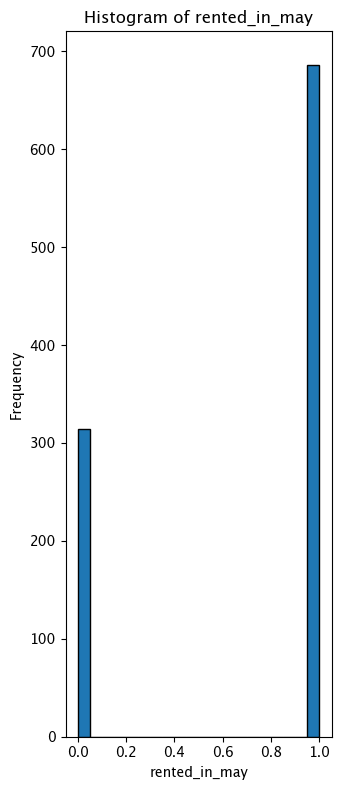

In [24]:
my_functions.plot_numeric_columns(df[['rented_in_may']], 'histogram')


### Relationship between Features and Target

In [26]:
for col in modeling_columns:
    if col not in data.columns:
        print(f"{col} does not exist in DataFrame")


category does not exist in DataFrame


In [27]:
modeling_columns = [col for col in modeling_columns if col != 'category']


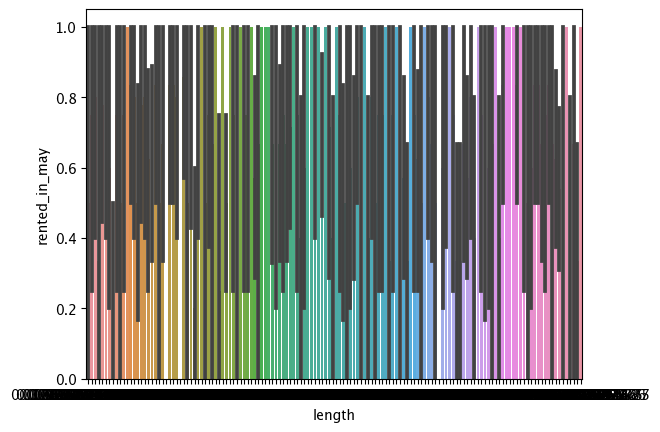

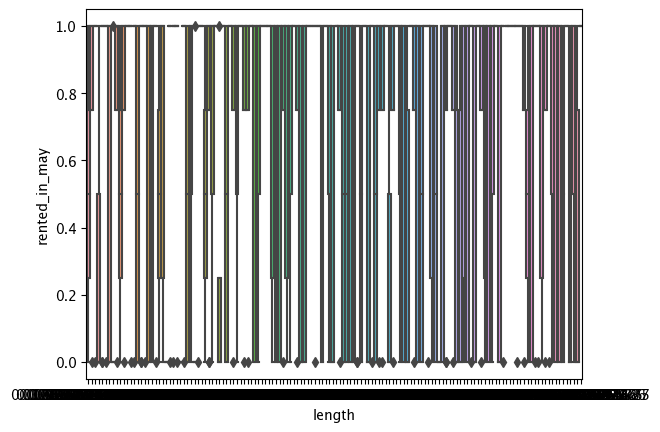

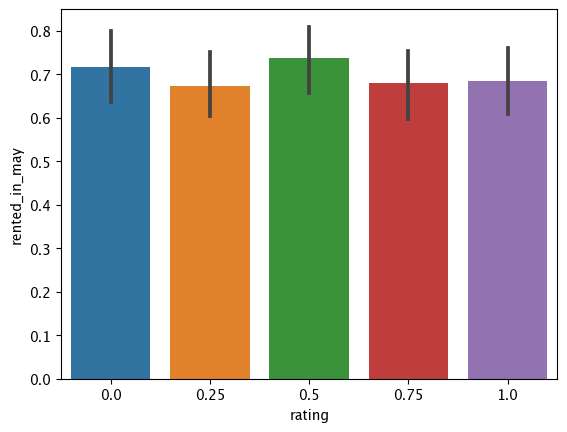

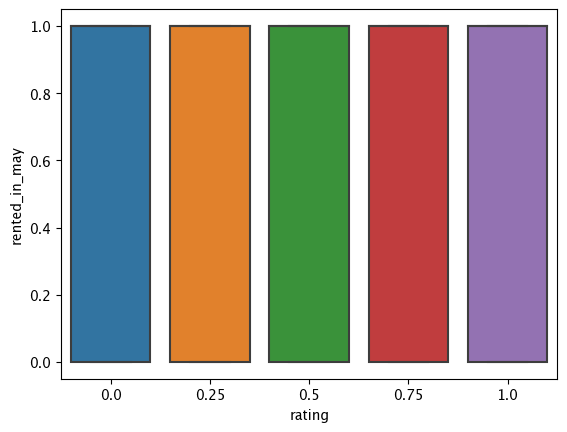

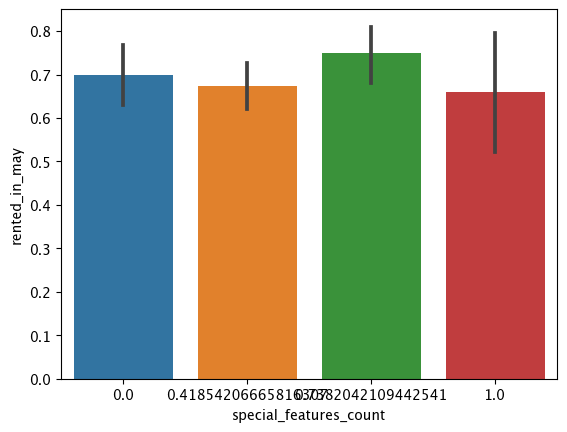

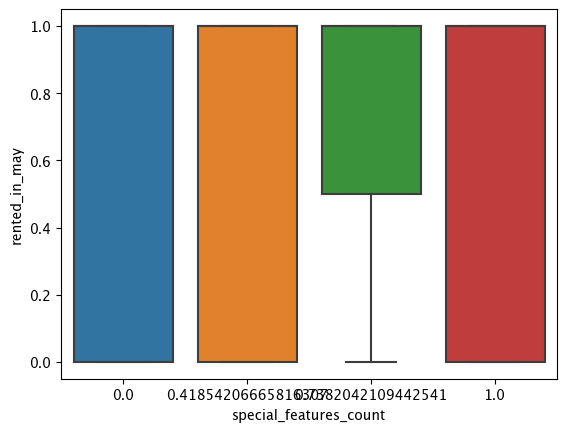

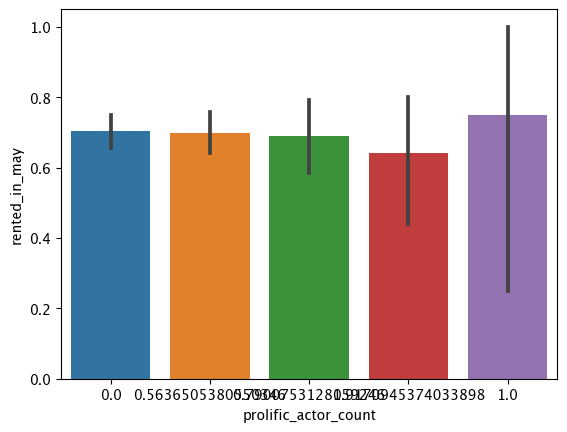

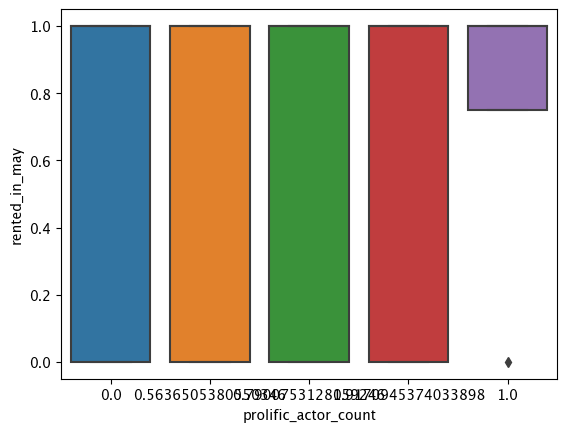

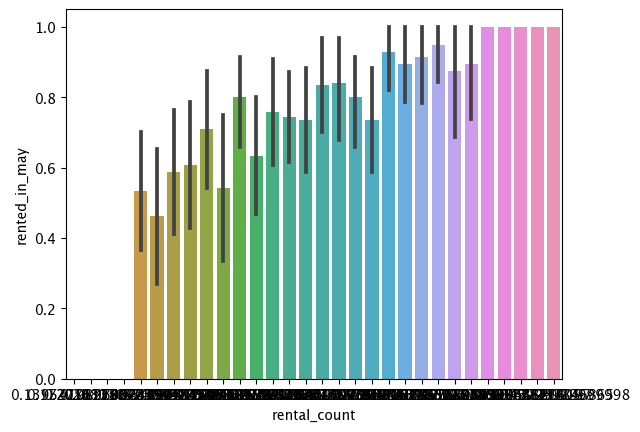

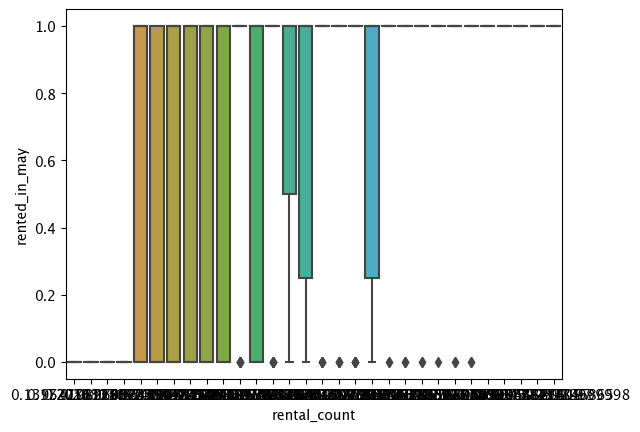

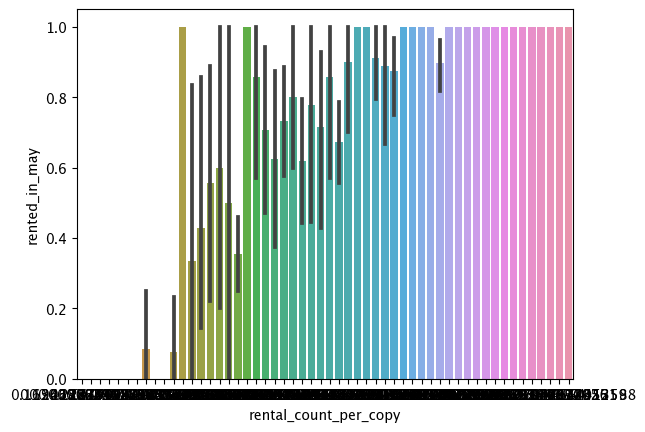

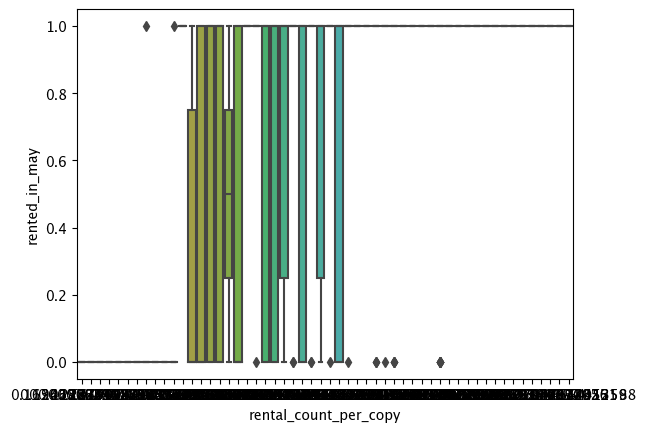

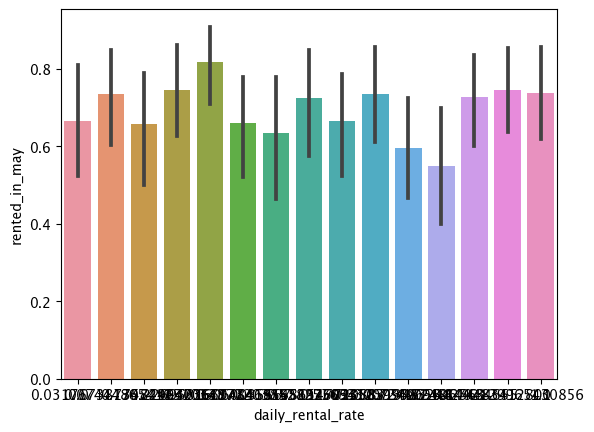

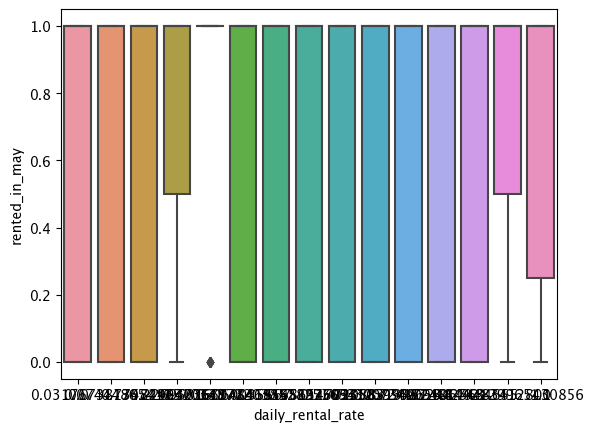

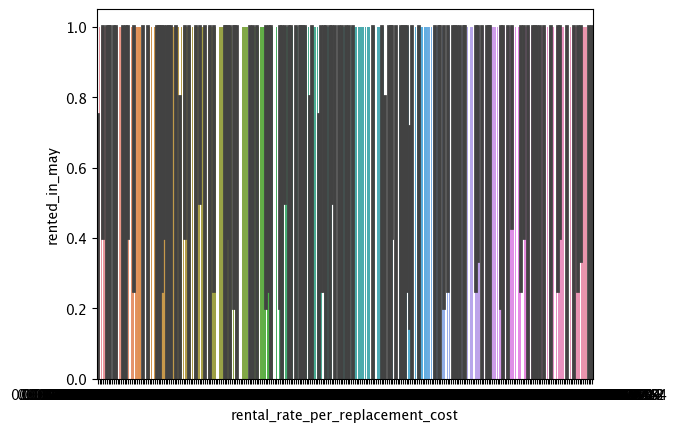

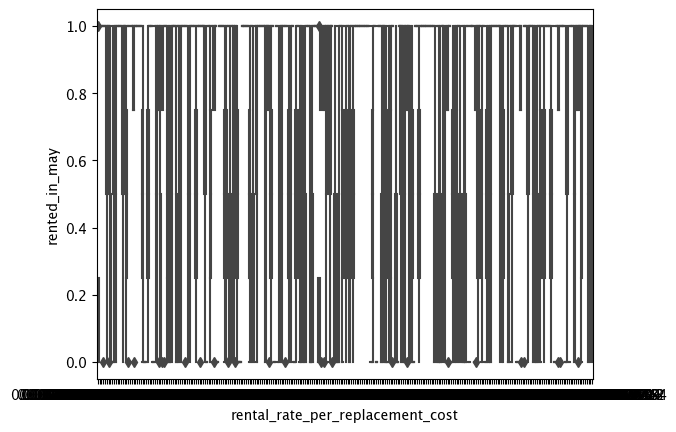

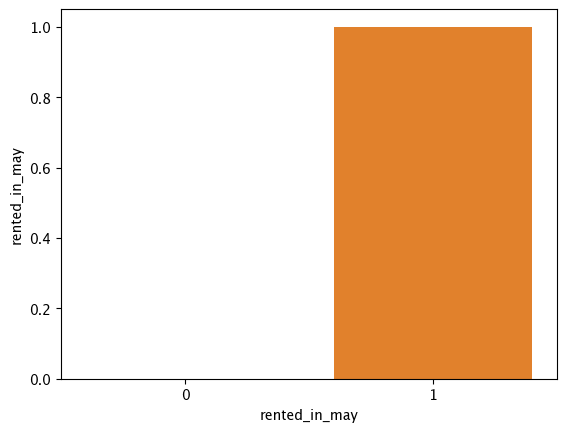

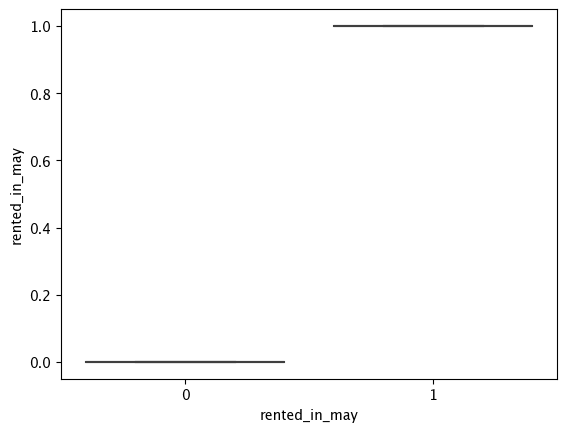

In [28]:

data = pd.concat([X_train_transformed_scaled_df, y_train], axis=1)

for col in modeling_columns:
    # Plot a bar plot of X variable vs categorical target variable
    sns.barplot(x=col, y='rented_in_may', data=data)
    # Display the plot
    plt.show()
    # Plot a box plot of X variable vs categorical target variable
    sns.boxplot(x=col, y='rented_in_may', data=data)
    # Display the plot
    plt.show()

### Correlation Analysis

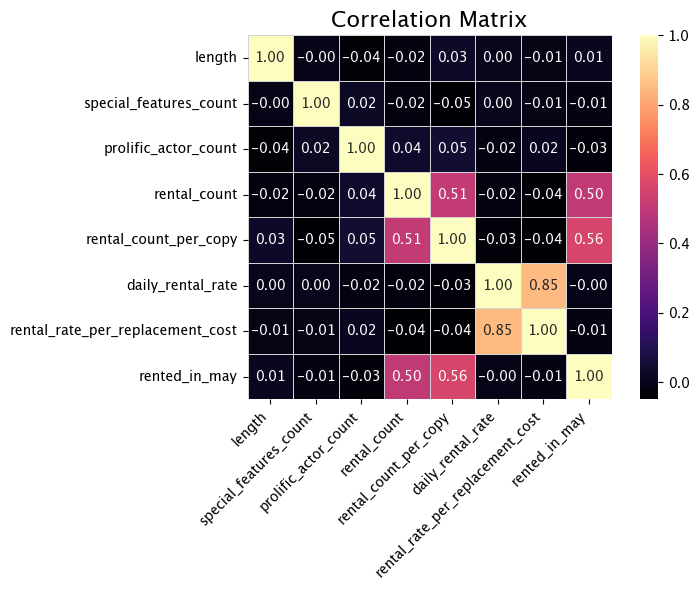

In [29]:
my_functions.plot_corr_matrix(df[modeling_columns])

## Model Building
***

### Training the Logistic Regression Model
- Code and explanation

In [30]:
# Select Logistic Regression model
model = LogisticRegression()

# Fit the model with the train data -> X_train_transformed_scaled_df
model.fit(X_train_transformed_scaled_df, y_train)

# Save model
path = "models/"
file_name = "linear_model.pkl"
my_functions.save_pickle_file(path, file_name, model)

The new directory is created!


In [31]:
# Make predictions with .predict()
y_train_pred = model.predict(X_train_transformed_scaled_df)
y_test_pred  = model.predict(X_test_transformed_scaled_df)

In [32]:
# Create a table with the results - Real vs. Predicted
results = {"Set": ["Train"]*X_train_transformed_scaled_df.shape[0] + 
           ["Test"]*X_test_transformed_scaled_df.shape[0], 
           "Real": list(y_train) + list(y_test),
           "Predicted": list(y_train_pred) + list(y_test_pred)}

# Create DataFrame
results_df = pd.DataFrame(results)

# Display first 5 rows
display(results_df.head(10))
results_df.describe()

,Set,Real,Predicted
0,Train,1,1
1,Train,1,1
2,Train,1,1
3,Train,1,1
4,Train,1,1
5,Train,1,1
6,Train,1,1
7,Train,0,1
8,Train,0,0
9,Train,1,1


,Real,Predicted
count,1000.000000,1000.000000
mean,0.686000,0.779000
std,0.464349,0.415128
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


## Model Evaluation
***

In [33]:
# Create table with absolute and relative errors for every row prediction of Train and Test data
results_df['abs_error'] = (results_df['Real'] - results_df['Predicted']).round(2)
# Display first 5 rows
results_df.head(20)

,Set,Real,Predicted,abs_error
0,Train,1,1,0
1,Train,1,1,0
2,Train,1,1,0
3,Train,1,1,0
4,Train,1,1,0
5,Train,1,1,0
6,Train,1,1,0
7,Train,0,1,-1
8,Train,0,0,0
9,Train,1,1,0


In [34]:
# Create error metrics DataFrame
error_metrics_df = my_functions.error_metrics_report(list(results_df[results_df["Set"]=="Train"]["Real"]),
                                            list(results_df[results_df["Set"]=="Test"]["Real"]),
                                            list(results_df[results_df["Set"]=="Train"]["Predicted"]),
                                            list(results_df[results_df["Set"]=="Test"]["Predicted"]))
# Display error metrics report
display(error_metrics_df)

,Metric,Train,Test
0,MAE,0.16,0.16
1,MSE,0.16,0.16
2,RMSE,0.39,0.40
3,R2,0.26,0.29


+ In conclusion, my model has a moderate performance. The errors (MAE, MSE, RMSE) are relatively low, which is good. 

+ However, the R2 score is also relatively low, which means my model only explains a small portion of the variance in your target variable. 

+ This suggests that there might be other variables or factors that my model isn't considering, or that a different modeling approach might be more effective.